<IPython.core.display.Javascript object>


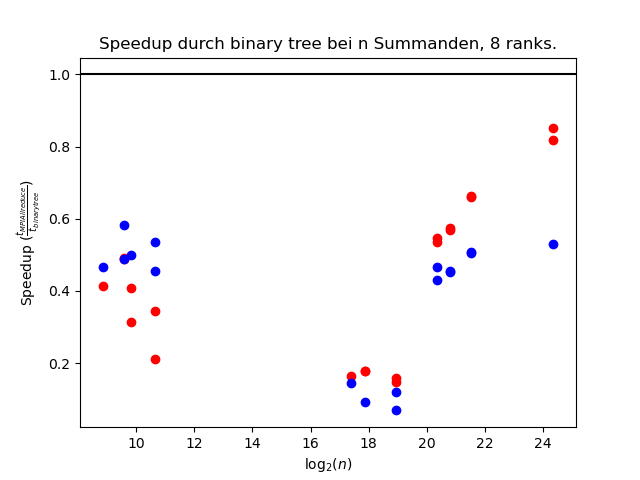

In [12]:
%matplotlib notebook
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

def fetch_data(cluster_size):
    con = sqlite3.connect('file:results.db?mode=ro', uri=True)
    cur = con.cursor()

    # Calculate of average over runs of maximum of ranks
    cur.execute("""
    CREATE TEMPORARY VIEW avg_of_max_rank_time_{} AS
        select n_summands, datafile, mode, AVG(time_us) as time_us from (
            select n_summands, datafile, mode, run, max(time_us) as time_us from results where cluster_size = {} group by datafile, mode, run
        ) group by datafile, mode;""".format(cluster_size, cluster_size))

    # Self-join to match columns and divide tree / mpi
    cur.execute("""
    SELECT a.n_summands, a.datafile, a.time_us / b.time_us FROM avg_of_max_rank_time_{} AS a, avg_of_max_rank_time_{} AS b
    WHERE a.datafile = b.datafile AND a.mode = 'mpi' AND b.mode = 'tree'
    """.format(cluster_size, cluster_size))

    return cur.fetchall()


data4 = fetch_data(4)
x4 = np.log2(list(map(lambda x: x[0], data4))) # n_summands
y4 = list(map(lambda x: x[2], data4)) # time_us

data8 = fetch_data(8)
x8 = np.log2(list(map(lambda x: x[0], data8))) # n_summands
y8 = list(map(lambda x: x[2], data8)) # time_us

f = plt.figure()

ax = f.subplots(1)
ax.set_title("Speedup durch binary tree bei n Summanden, 8 ranks.")
ax.axhline(1.0, color='black')
ax.set_ylabel('Speedup ($\\frac{t_{MPI Allreduce}}{t_{binary tree}}$)')
ax.set_xlabel('$\\log_2(n)$')
ax.scatter(x4, y4, color='red')
ax.scatter(x8, y8, color='blue')
plt.show()
plt.savefig(fname="figure.svg")